# 基于时间序列的异常检测

In [97]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import accuracy_score
import onnx
import onnxruntime as ort
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_fscore_support

import warnings

warnings.filterwarnings("ignore")

## 基础知识

## TimesNet异常检测

### 数据准备

In [41]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [43]:
data_path = "../data/energy_AD.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp,label
2012-01-01 00:00:00,2698.0,32.00,0.0
2012-01-01 01:00:00,2558.0,32.67,0.0
2012-01-01 02:00:00,2444.0,30.00,0.0
2012-01-01 03:00:00,2402.0,31.00,0.0
2012-01-01 04:00:00,2403.0,32.00,0.0
...,...,...,...
2014-12-31 19:00:00,4012.0,18.00,0.0
2014-12-31 20:00:00,3856.0,16.67,0.0
2014-12-31 21:00:00,3671.0,17.00,0.0
2014-12-31 22:00:00,3499.0,15.33,0.0


In [44]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [45]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [47]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["label"],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/TimesNet_AD'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 1) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 1) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 1) stamp_test shape: (5261, 4)


In [52]:
# 异常检测不需要y，直接对x进行重构
def generator_ad(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i - seq_len:i + 1]
        X.append(np.array(feat))
        y.append(np.array(tar))
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i - seq_len:i + 1]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [53]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 0, 
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator_ad(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator_ad(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator_ad(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18407, 6, 2]),y_size: torch.Size([18407, 6, 1]),loader_len: 576
X_size: torch.Size([2626, 6, 2]),y_size: torch.Size([2626, 6, 1]),loader_len: 83
X_size: torch.Size([5256, 6, 2]),y_size: torch.Size([5256, 6, 1]),loader_len: 165


### 模型定义

In [50]:
# 位置编码，是对于每一条序列位置的编码，和具体的值无关
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        # 注意：d_model需要是偶数
        # 0::2：从0开始，以步长为2进行取值，取到的都是偶数位置
        pe[:, 0::2] = torch.sin(position * div_term)
        # 1::2：从1开始，以步长为2进行取值，取到的都是奇数位置
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # 作用是该组参数不会更新，但是保存模型时，该组参数又作为模型参数被保存
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]
    
# 使用conv1d的目的是要对序列中的每一个时间点上的数据（也就是token）来做编码
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x
    
class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

# 是对于时间戳的编码（协变量），和序列本身的位置、数值无关
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()
        
        # freq拆分
        number = re.findall('[0-9]', freq)
        number = 1 if len(number)==0 else int(''.join(number))
        string = re.findall('[a-z]', freq)[0]
        if string == 'h':
            hour_size = int(24 / number)
        elif string == 't':
            hour_size = 24
            minute_size = int(60 / number)
        elif string == 's':
            hour_size = 24
            minute_size = 60
            second_size = int(60 / number)
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        if freq == 's':
            self.second_embed = Embed(second_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        second_x = self.second_embed(x[:, :, 5]) if hasattr(
            self, 'second_embed') else 0.
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x + second_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

# 将不同的卷积层通过并联的方式结合在一起，经过不同卷积层处理的结果矩阵在深度这个维度拼接起来，形成一个更深的矩阵
class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels # 卷积核尺寸
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res
    
# 快速傅里叶变换，返回周期长度和频率
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, seq_len, pred_len, top_k, d_model, d_ff, num_kernels):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.k = top_k # 强度最大的K个频率，不宜过大，容易出现0的情况
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(d_model, d_ff, num_kernels=num_kernels),
            nn.GELU(),
            Inception_Block_V1(d_ff, d_model, num_kernels=num_kernels)
        )

    def forward(self, x):
        B, T, C = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period, C).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, C)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # 自适应融合
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, C, 1)
        res = torch.sum(res * period_weight, -1)
        # 残差连接
        res = res + x
        return res
    
# TimesNet模型
class TimesNet(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, top_k, d_model, d_ff, 
                 num_kernels, e_layers, enc_in, dropout, c_out, embed, freq):
        super(TimesNet, self).__init__()
        self.seq_len = seq_len # 输入序列长度
        self.pred_len = pred_len # 输出序列长度
        self.model = nn.ModuleList([TimesBlock(self.seq_len, self.pred_len, top_k, d_model, d_ff, num_kernels) 
                                    for _ in range(e_layers)])
        self.enc_embedding = DataEmbedding(enc_in, # 编码器维度
                                           d_model, # 隐藏层维度
                                           embed, # 时间特征编码，[timeF, fixed, learned]
                                           freq, # 时间特征编码频率，[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly]
                                           dropout)
        self.layer = e_layers # TimesBlock层数
        self.layer_norm = nn.LayerNorm(d_model)
        self.predict_linear = nn.Linear(self.seq_len, self.pred_len + self.seq_len)
        self.projection = nn.Linear(d_model, c_out, bias=True) # 输出序列维度

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        # embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
        enc_out = self.predict_linear(enc_out.permute(0, 2, 1)).permute(0, 2, 1)  # align temporal dimension
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # porject back
        dec_out = self.projection(enc_out)

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * \
                  (stdev[:, 0, :].unsqueeze(1).repeat(
                      1, self.pred_len + self.seq_len, 1))
        dec_out = dec_out + \
                  (means[:, 0, :].unsqueeze(1).repeat(
                      1, self.pred_len + self.seq_len, 1))
        
        # output
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [51]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            outputs = model(batch_x, None, None, None)
            train_loss = criterion(outputs, batch_x)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                outputs = model(batch_x, None, None, None)
                val_loss = criterion(outputs, batch_x)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

 10%|████████▏                                                                         | 1/10 [01:49<16:29, 109.99s/it]

Epoch [1/10], Training Loss: 0.0001, Validation Loss: 0.0000
Validation loss decreased (inf --> 0.000012).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▍                                                                 | 2/10 [03:27<13:40, 102.56s/it]

Epoch [2/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000012 --> 0.000009).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [04:57<11:18, 96.90s/it]

Epoch [3/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000009 --> 0.000007).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [06:25<09:21, 93.53s/it]

Epoch [4/10], Training Loss: 0.0000, Validation Loss: 0.0000
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [07:53<07:36, 91.38s/it]

Epoch [5/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000007 --> 0.000005).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [09:30<06:13, 93.25s/it]

Epoch [6/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000005 --> 0.000003).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:14<04:50, 96.84s/it]

Epoch [7/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000003 --> 0.000003).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [13:03<03:21, 100.58s/it]

Epoch [8/10], Training Loss: 0.0000, Validation Loss: 0.0000
EarlyStopping counter: 1 out of 3
Updating learning rate to 9.549150281252633e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [14:54<01:44, 104.02s/it]

Epoch [9/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000003 --> 0.000002).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [16:40<00:00, 100.10s/it]

Epoch [10/10], Training Loss: 0.0000, Validation Loss: 0.0000
Validation loss decreased (0.000002 --> 0.000002).  Saving model ...
Updating learning rate to 0.0


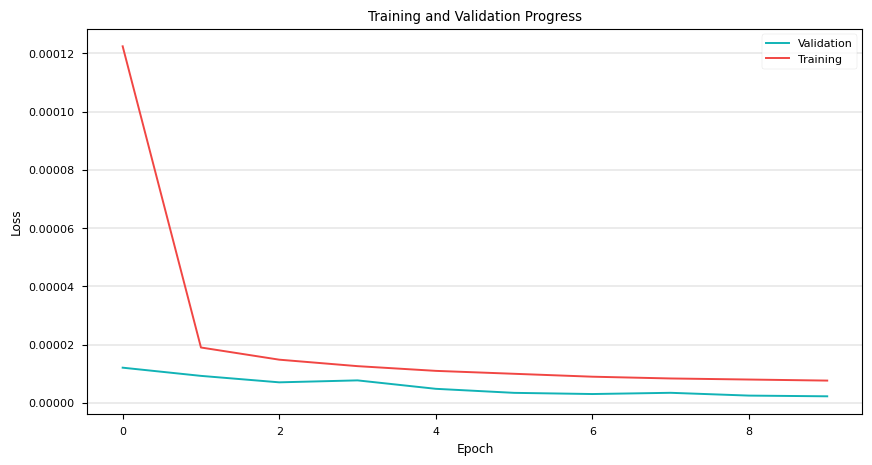

In [11]:
# 构造参数字典
params3 = {
    "train_args": {
        "model_name": TimesNet,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 10,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/TimesNet_AD",
        "device": 'cpu',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 0,
        "label_len": 0,
        'top_k': 3,
        'd_model': 32,
        'num_kernels': 6,
        'embed': 'fixed',
        'freq': 'h',
        'd_ff': 32,
        'dropout': 0.1,
        'e_layers': 2,
        'enc_in': 2,
        'c_out': 2,
    },
}
model = train(**params3)

### 输出修正

想要判断异常检测模型性能的好坏，我们需要将模型的输出数据和标签数据根据各种不同的评价指标做对比。然而，倘若我们直接用两者做对比，得分会比较低，并且也不符合实际情况。实际情况下，我们认为我们**只要判断出连续异常点中的一个异常点，就可以认为找到了这一段异常点**。因此，我们必须对异常检测的输出进行修正。

例子（0为正常，1为异常）  
预测值为： [0 0 0 0 0 1 0 0 1]  
标签值为： [0 1 1 0 1 1 1 0 0]  
我们希望修正后的输出值为：[0 0 0 0 **1** 1 **1** 0 1]  
加粗的1是我们修正加上去的。

In [92]:
def adjustment(gt, pred):
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1
    return gt, pred

### 模型测试

In [108]:
def test(test_args):
    # 参数配置
    model = test_args['model']
    train_loader = test_args['train_loader']  # 训练集
    test_loader = test_args['test_loader']  # 测试集
    loss = test_args['loss']  # 损失函数
    anomaly_ratio = test_args['anomaly_ratio']  # 每百个异常个数，异常比例
    device = test_args['device']  # 可选'cuda'和'cpu'
    test_path = test_args['test_path']  # 结果保存路径

    #检查是否可用GPU
    device = torch.device(device)

    # 设置结果保存路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # 创建损失函数，reduce=False函数返回的是一个batch中每个样本的损失，结果为向量
    criterion = nn.MSELoss(
        reduce=False)  

    # 关闭自动求导功能
    model.eval()
    attens_energy = []

    # (1) 训练集误差评估
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark,
                batch_y_mark) in enumerate(train_loader):
            batch_x = batch_x.to(device)
            # reconstruction
            outputs = model(batch_x, None, None, None)
            # criterion
            score = torch.mean(criterion(outputs, batch_x), dim=-1)
            score = score.detach().cpu().numpy()
            attens_energy.append(score)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    train_energy = np.array(attens_energy)

    # (2) 测试集误差评估并确定阈值
    attens_energy = []
    test_labels = []
    for i, (batch_x, batch_y, batch_x_mark,
            batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.to(device)
        # reconstruction
        outputs = model(batch_x, None, None, None)
        # criterion
        score = torch.mean(criterion(outputs, batch_x), dim=-1)
        score = score.detach().cpu().numpy()
        attens_energy.append(score)
        test_labels.append(batch_y)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    test_energy = np.array(attens_energy)
    combined_energy = np.concatenate([train_energy, test_energy], axis=0)
    threshold = np.percentile(combined_energy, 100 - anomaly_ratio)
    print("Threshold :", threshold)

    # (3) 测试集误差评估
    pred = (test_energy > threshold).astype(int)
    test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
    test_labels = np.array(test_labels)
    gt = test_labels.astype(int)

    # (4) 异常检测输出修正
    gt, pred = adjustment(gt, pred)
    pred = np.array(pred)
    gt = np.array(gt)

    accuracy = accuracy_score(gt, pred)
    precision, recall, f_score, support = precision_recall_fscore_support(
        gt, pred, average='binary')
    print(
        "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} "
        .format(accuracy, precision, recall, f_score))

    # 结果保存
    f = open(test_path + "/result_anomaly_detection.txt", 'a')
    f.write(
        "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} "
        .format(accuracy, precision, recall, f_score))
    f.write('\n')
    f.close()

    return 0

In [109]:
# 构造参数字典
params4 = {
    "test_args": {
        "model": model,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "loss": nn.MSELoss(),
        "anomaly_ratio": 1,
        'device': 'cpu',
        'test_path': '../outputs/results/TimesNet_AD'
    }
}
res = test(**params4)

Threshold : 1.6112337762024263e-05
Accuracy : 0.9878, Precision : 0.0000, Recall : 0.0000, F-score : 0.0000 


### 模型预测